## Project 3: Classification Modeling and Natural Language Processing of Reddit posts
---

### Problem Statement

In this project, we were tasked with creating classification models to predict the subreddit of origin based on documents of text scraped from posts on various subreddits. While my initial goal was to use natural language processing techniques to determine the differentiators between the subreddits for the two most popular sports leagues in the United States, the NFL and the NBA. However, after my initial assessment, I wanted to dive deeper, and compare these leagues to their collegiate equivalents to see how they differentiate in their language.

My goal in analyzing the language in all four of these subreddits was to determine which topics or trends separate the Reddit discussions of these leagues the most. I will look at the most important word features for each model and asses the performance of each model to draw my conclusions.

### Contents:
- [EDA and Preprocessing](#EDA-and-Preprocessing)
- [Multinomial Naive Bayes Model](#Multinomial-Naive-Bayes-Model)
- [Support Vector Machine Clssifier](#Support-Vector-Machine-Classifier)
- [SVM: r/nba and r/Collegebasketball](#Support-Vector-Machine-Classifier:-r/nba-vs.-r/CollegeBasketball)
- [SVM: r/nfl and r/cfb](#Support-Vector-Machine-Classifier:-r/nfl-vs.-r/cfb)

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import requests, re

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# import subreddit data
cbb_df = pd.read_csv('./data/cbb_subreddit_data.csv')
cfb_df = pd.read_csv('./data/cfb_subreddit_data.csv')
nba_df = pd.read_csv('./data/nba_subreddit_data.csv')
nfl_df = pd.read_csv('./data/nfl_subreddit_data.csv')

## EDA and Preprocessing
---

In [3]:
# check shape of dataframes
print(cbb_df.shape)
print(cfb_df.shape)
print(nba_df.shape)
print(nfl_df.shape)

(1995, 104)
(1984, 103)
(2759, 100)
(2976, 100)


In [4]:
# define function to combine two subsets of columns
# fills NaN's with null strings to ensure compatability
def combine_text(df, cols):
    for col in cols:
        df[col] = df[col].fillna(value = "")
    return df[cols].apply(lambda x: ''.join(x), axis=1)

In [5]:
# run combine text on politics posts
cbb_df['text'] = combine_text(cbb_df, ['title', 'selftext'])

In [6]:
# run combine text on politics posts
cfb_df['text'] = combine_text(cfb_df, ['title', 'selftext'])

In [7]:
# run combine text on nfl posts
nfl_df['text'] = combine_text(nfl_df, ['title', 'selftext'])

In [8]:
# run combine text on nba posts
nba_df['text'] = combine_text(nba_df, ['title', 'selftext'])

In [9]:
# reshape dataframes to only include text, name, and subreddit columns
nba_df = nba_df[['text', 'name', 'subreddit']]
nfl_df = nfl_df[['text', 'name', 'subreddit']]
cbb_df = cbb_df[['text', 'name', 'subreddit']]
cfb_df = cfb_df[['text', 'name', 'subreddit']]

In [10]:
# drop duplicate posts based on the post name ID
nba_df = nba_df.drop_duplicates(subset=['name'])
cfb_df = cfb_df.drop_duplicates(subset=['name'])
cbb_df = cbb_df.drop_duplicates(subset=['name'])
nfl_df = nfl_df.drop_duplicates(subset=['name'])

In [11]:
# concat the nfl and nba dataframes
reddit = pd.concat([nfl_df, nba_df], ignore_index=True)

In [12]:
# concat the nfl and nba dataframes
reddit_bb = pd.concat([cbb_df, nba_df], ignore_index=True)

In [13]:
# concat the nfl and nba dataframes
reddit_fb = pd.concat([cfb_df, nfl_df], ignore_index=True)

In [14]:
# define function to run same regex over a dataframe
def sub_preprocess(sub):
    # run regex to remove urls
    sub['text'] = sub['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove certain characters
    sub['text'] = sub['text'].map(lambda x: re.sub(r"[@\?\.$%_\[\]()+-:*\"]", ' ', x, flags=re.I))
    sub['text'] = sub['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))
    sub['text'] = sub['text'].map(lambda x: re.sub("(?<![\w'])\w+?(?=\b|'s)", ' ', x))

    # run regex to remove line breaks and tabs
    sub['text'] = sub['text'].map(lambda x: re.sub(r"\s+", ' ', x))

    # run regex to remove common words
    sub['text'] = sub['text'].map(lambda x: re.sub('(nfl|nba|college|ncaa|team|game|season|year|player|thread|just|like|time|new)[s]?', ' ', x,  flags=re.I))   

In [15]:
# run the regex function on our dataframes
sub_preprocess(reddit_bb)
sub_preprocess(reddit_fb)
sub_preprocess(reddit)

In [16]:
# create new columns for our predicted variable, normalize value counts to get the baseline score
reddit['is_nba'] = reddit['subreddit'].map({'nba': 1, 'nfl': 0})
reddit['is_nba'].value_counts(normalize=True)

1    0.535724
0    0.464276
Name: is_nba, dtype: float64

In [17]:
# create new columns for our predicted variable, normalize value counts to get the baseline score
reddit_bb['is_nba'] = reddit_bb['subreddit'].map({'nba': 1, 'CollegeBasketball': 0})
reddit_bb['is_nba'].value_counts(normalize=True)

1    0.522422
0    0.477578
Name: is_nba, dtype: float64

In [18]:
# create new columns for our predicted variable, normalize value counts to get the baseline score
reddit_fb['is_nfl'] = reddit_fb['subreddit'].map({'nfl': 1, 'CFB': 0})
reddit_fb['is_nfl'].value_counts(normalize=True)

0    0.510143
1    0.489857
Name: is_nfl, dtype: float64

In [19]:
reddit.columns

Index(['text', 'name', 'subreddit', 'is_nba'], dtype='object')

## Multinomial Naive Bayes Model
---

In this section, I run a Multinomial Naive Bayes (NB) model with both a Count Vectorizer and a TF-IDF Vectorizer. I used ScikitLearn's GridSearch Cross Validation to find the optimal hyperparamters for each model, and ran the models again with the optimal hyperparameters.

Overall, both models performed very well, but the NB using a Count Vectorizer performed the best, with accuracy score of 95.33% on the testing data and a weighted accuracy of 94%. 

The TF-IDF Vectorized model wasn't quite as accurate, but still posted an accuracy score of 93.76% on the testting set and a weighted precision of 94%.

#### Multinomial Naive Bayes and TF-IDF Vectorizer
---

In [20]:
# train/test split our data
X = reddit['text']
y = reddit['is_nba']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [21]:
# instantiate pipeline
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [22]:
# define gridsearch hyperparameters
tfidf_params = {
    'tfidf__max_features': [2000, 5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [.60, .75, .90],
    'tfidf__stop_words': [None, 'english']
}

In [23]:
# run gridsearch
tfidf_gs = GridSearchCV(tfidf_pipe, param_grid=tfidf_params, cv=3, n_jobs=4)
tfidf_gs.fit(X_train, y_train)

# display best hyperparameters
tfidf_gs.best_params_

{'tfidf__max_df': 0.6,
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

In [24]:
# check score from training data
tfidf_gs.score(X_train, y_train)

0.9788634788634789

In [25]:
# check score from predictions on testing data
y_pred_class = tfidf_gs.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9376947040498442

#### Multinomial Naive Bayes and Count Vectorizer
---

In [26]:
# instantiate pipeline
cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [27]:
# define gridsearch parameters
cvec_params = {
    'cvec__max_features': [2000, 5000, 10000, 20000],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [.60, .75, .95],
    'cvec__stop_words': [None, 'english']
}

In [28]:
# run gridsearch
cvec_gs = GridSearchCV(cvec_pipe, param_grid=cvec_params, cv=3, n_jobs=4)
cvec_gs.fit(X_train, y_train)

# display best hyperparameters
cvec_gs.best_params_

{'cvec__max_df': 0.6,
 'cvec__max_features': 20000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [29]:
# check score from training data
cvec_gs.score(X_train, y_train)

0.9823284823284824

In [30]:
# check score from predictions on testing data
y_pred_class = cvec_gs.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9532710280373832

#### Visualizations and Analysis: TF-IDF with Multinomial Naive Bayes, using best hyperparameters
---

The TF-IDF model posted an accuracy score of 93.39% on the testing set with a weighted accuracy of 94%. This model correctly predicted whether a post was in r/nfl 98% of the time, and r/nba 91%.

The most important words for the model in classifying a post from r/nba referenced free agency moves like "westbrook", "kawhi", "lebron", while the most important words in classfying a post from r/nfl were terms found in discussions about the actual football game, like "highlight", "yard", and "td".

In [31]:
# use the parameters found in the gridsearch
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000, max_df=0.60)

In [32]:
# run the TF-IDF vectorized model with optimal parameters
train_raw = tfidf.fit_transform(X_train)
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())

test_raw = tfidf.transform(X_test)
test_df = pd.SparseDataFrame(test_raw, columns=tfidf.get_feature_names())

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [33]:
tfidf_nb = MultinomialNB()
tfidf_nb.fit(train_df, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [34]:
# score model on testing set
tfidf_nb.score(test_raw, y_test)

0.9397715472481828

In [35]:
# define fucntion to determine the most useful features for  Multinomial NB classifiers
def nb_features(vectorizer, classifier, n=20, class_labels=[0, 1]):
    
    # get list of feature names from the vectorizor
    feature_names = vectorizer.get_feature_names()
    
    # two lists of tuples that contain the log probability from the classifier
    # tie it to the corresponding feature names, sort the list by highest log probability
    top_class0 = sorted(zip(classifier.feature_log_prob_[0], feature_names), reverse=True)[:n]
    top_class1 = sorted(zip(classifier.feature_log_prob_[1], feature_names), reverse=True)[:n]
    # credit to Sai Sandeep on StackOverflow for giving the basis for the zip method of tying names and counts together
    
    print(f"Important words in classifying posts for {class_labels[0]}")
    
    # print label, the exponential of the log probability,  and the feature names
    for prob, feat in top_class0:
        print(class_labels[0], np.exp(prob), feat)

    print(" ")
    print(" ")
    print(f"Important words in classifying posts for {class_labels[1]}")

    for prob, feat in top_class1:
        print(class_labels[1], np.exp(prob), feat)

In [36]:
nb_features(tfidf, tfidf_nb, class_labels=['r/nfl', 'r/nba'])

Important words in classifying posts for r/nfl
r/nfl 0.00199096438017571 highlight
r/nfl 0.0012183280562030698 qb
r/nfl 0.001162659102439336 yards
r/nfl 0.0011079726642718535 browns
r/nfl 0.0010848559871524553 bowl
r/nfl 0.0010460370130334338 patriots
r/nfl 0.0009954515768307612 td
r/nfl 0.0009728242417250785 super
r/nfl 0.000924483355958119 super bowl
r/nfl 0.0009026869915810785 best
r/nfl 0.0008618936674885273 day
r/nfl 0.0008323756448570636 pick
r/nfl 0.0008284419070066697 brady
r/nfl 0.0008097690613953096 football
r/nfl 0.0007981834488826579 yard
r/nfl 0.000797064483028153 draft
r/nfl 0.0007634036274632053 today
r/nfl 0.0007564432957503686 wr
r/nfl 0.0007555563648761836 pass
r/nfl 0.000740498416644244 round
 
 
Important words in classifying posts for r/nba
r/nba 0.0018053611624839843 kawhi
r/nba 0.00160511303723205 westbrook
r/nba 0.0015325461500301175 lebron
r/nba 0.0014823974451679174 lakers
r/nba 0.001395116727764982 clippers
r/nba 0.0013646935998835783 trade
r/nba 0.0013432372

In [37]:
# create dataframes for plotting NB results
# note that exponential is taken from the log probability to get the actual probability for each feature
nb_feat_importance_nfl = pd.DataFrame(np.exp(tfidf_nb.feature_log_prob_[0]), train_df.columns, columns=['probability'])
nb_feat_importance_nba = pd.DataFrame(np.exp(tfidf_nb.feature_log_prob_[1]), train_df.columns, columns=['probability'])

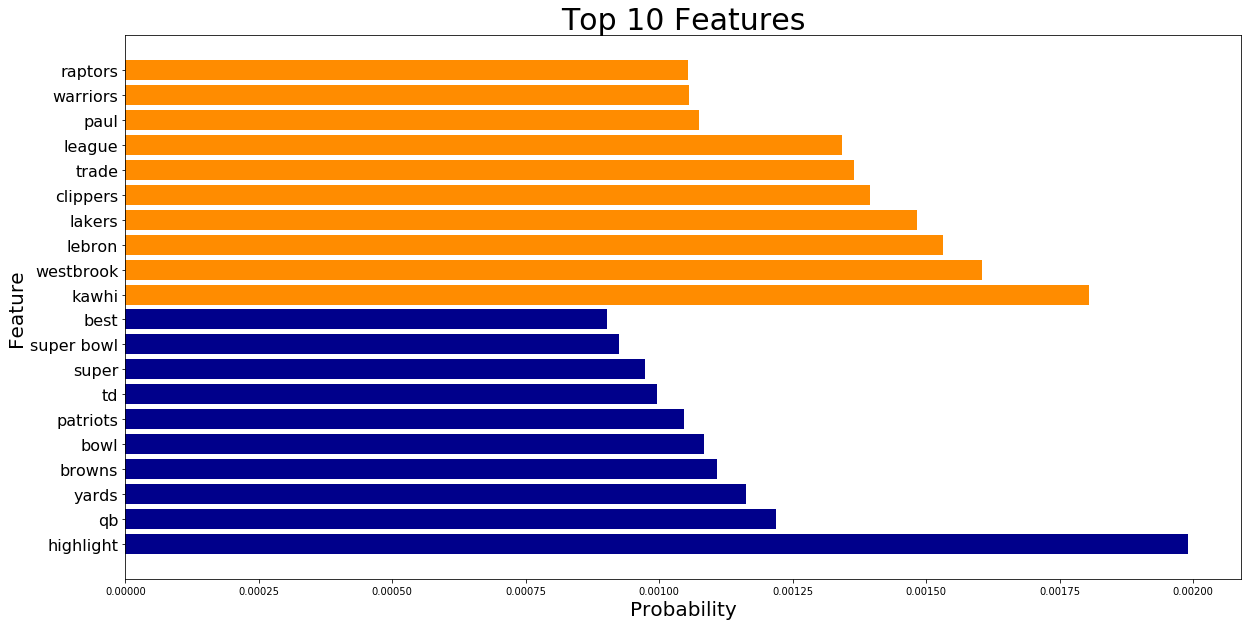

In [38]:
# plot the results from the NB dataframes
plt.figure(figsize=(20,10))
nfl = nb_feat_importance_nfl.sort_values('probability', ascending=False).head(10)
nba = nb_feat_importance_nba.sort_values('probability', ascending=False).head(10)

plt.barh(nfl.index, nfl['probability'], color='darkblue')
plt.barh(nba.index, nba['probability'], color='darkorange')
plt.yticks(size=16)

plt.title('Top 10 Features', fontsize=30)
plt.xlabel('Probability', fontsize=20)
plt.ylabel('Feature', fontsize=20);

In [39]:
nb_counts_nfl = pd.DataFrame(tfidf_nb.feature_count_[0], train_df.columns, columns=['weighted_count'])
nb_counts_nba = pd.DataFrame(tfidf_nb.feature_count_[1], train_df.columns, columns=['weighted_count'])

In [40]:
nb_counts_nba.sort_values(by=['weighted_count'], ascending=False).head(20)

,weighted_count
kawhi,28.959956
westbrook,25.636839
lebron,24.432592
lakers,23.600375
clippers,22.151952
trade,21.647081
league,21.291013
paul,16.820710
warriors,16.514640
raptors,16.492821


In [41]:
nb_counts_nfl.sort_values(by=['weighted_count'], ascending=False).head(20)

,weighted_count
highlight,28.960909
qb,17.333937
yards,16.496206
browns,15.673261
bowl,15.325391
patriots,14.741226
td,13.979994
super,13.639488
super bowl,12.912033
best,12.584032


In [42]:
# define function to create confusion matrix and classification report
def make_cm(model, X, y, names):
    
    #get predictions from the model and plot the against the actual values in a confusion matrix
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    # convert confusion matrix to dataframe
    cols = ['pred_' + c for c in names]
    dfcm = pd.DataFrame(cm, columns=cols, index=names)
    
    # print confusion matrix and classification report
    print(dfcm)
    print("--------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    
    # credit adi brohstein for the basis for this code

In [43]:
# run confusion matrix function
make_cm(tfidf_nb, test_raw, y_test, ['r/nfl', 'r/nba'])

       pred_r/nfl  pred_r/nba
r/nfl         399          48
r/nba          10         506
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       447
           1       0.91      0.98      0.95       516

    accuracy                           0.94       963
   macro avg       0.94      0.94      0.94       963
weighted avg       0.94      0.94      0.94       963



#### Visualizations and Analysis: Count Vectorizer with Mulitnomial Naive Bayes, using best hyperparameters
---

The Count Vectorized model posted an accuracy score of 95.37% on the testing set with a weighted accuracy of 95%. This model correctly predicted whether a post was in r/nfl 97% of the time, and r/nba 93%.

The most important words for the model in classifying a post from r/nba, again, referenced free agency moves like "westbrook", "kawhi", "lebron", but weighted more related terms like "trade" and "pick" as important. The most important words in classfying a post from r/nfl were slightly different from the TF-IDF model, with "day" having the highest count, and more generalized terms like "round" and "pass" being important in predicting r/nfl posts.

In [44]:
# use the parameters found in the gridsearch
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20000, max_df=0.60)

In [45]:
# run the Count Vectorized model with the optimal hyperparameters
train_raw = cvec.fit_transform(X_train)
train_df = pd.SparseDataFrame(train_raw, columns=cvec.get_feature_names())

test_raw = cvec.transform(X_test)
test_df = pd.SparseDataFrame(test_raw, columns=cvec.get_feature_names())

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [46]:
cvec_nb = MultinomialNB()
cvec_nb.fit(train_df, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
# score 
cvec_nb.score(test_raw, y_test)

0.9532710280373832

In [48]:
# create dataframes for plotting NB results
# note that exponential is taken from the log probability to get the actual probability for each feature
nb_feat_importance_nfl = pd.DataFrame(np.exp(cvec_nb.feature_log_prob_[0]), train_df.columns, columns=['probability'])
nb_feat_importance_nba = pd.DataFrame(np.exp(cvec_nb.feature_log_prob_[1]), train_df.columns, columns=['probability'])

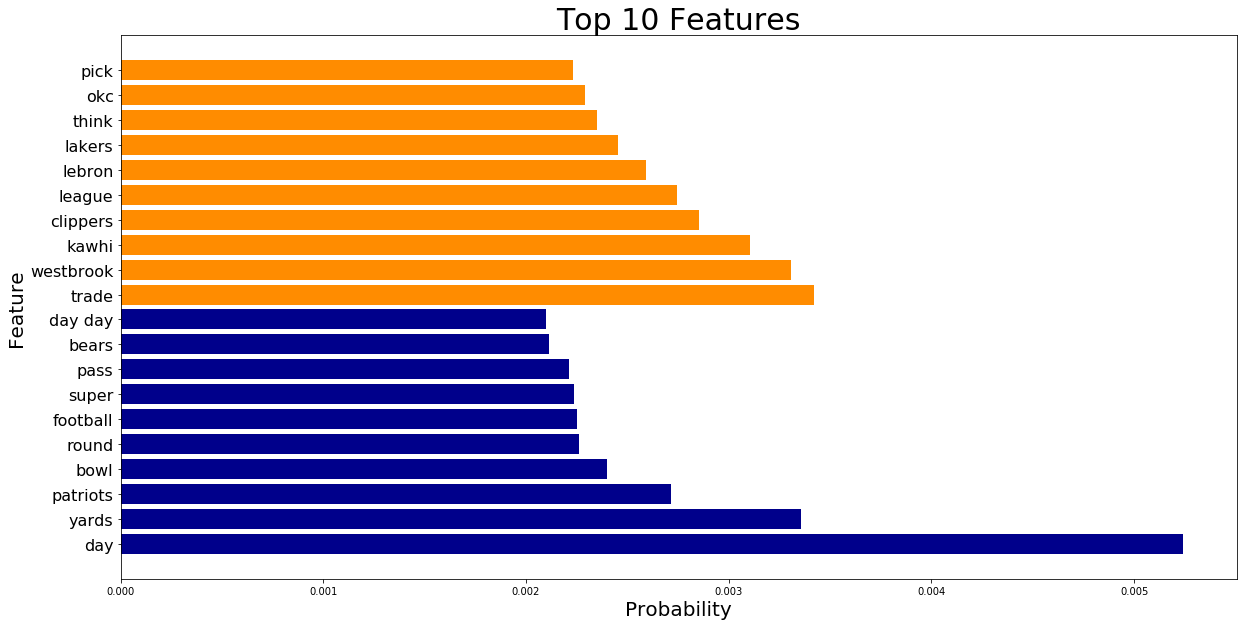

In [49]:
# plot the results from the NB dataframes
plt.figure(figsize=(20,10))
nfl = nb_feat_importance_nfl.sort_values('probability', ascending=False).head(10)
nba = nb_feat_importance_nba.sort_values('probability', ascending=False).head(10)

plt.barh(nfl.index, nfl['probability'], color='darkblue')
plt.barh(nba.index, nba['probability'], color='darkorange')
plt.yticks(size=16)

plt.title('Top 10 Features', fontsize=30)
plt.xlabel('Probability', fontsize=20)
plt.ylabel('Feature', fontsize=20);

In [50]:
nb_features(cvec, cvec_nb, class_labels=['r/nfl', 'r/nba'])

Important words in classifying posts for r/nfl
r/nfl 0.005242842953593929 day
r/nfl 0.003356928222085322 yards
r/nfl 0.0027157172133723956 patriots
r/nfl 0.0024013980914542937 bowl
r/nfl 0.002263097677810329 round
r/nfl 0.002250524912933605 football
r/nfl 0.0022379521480568806 super
r/nfl 0.0022128066183034318 pass
r/nfl 0.0021122244992896402 bears
r/nfl 0.002099651734412917 day day
r/nfl 0.0020242151451525725 play
r/nfl 0.001961351320768952 league
r/nfl 0.0019362057910155045 super bowl
r/nfl 0.0019362057910155045 amp
r/nfl 0.0019236330261387792 td
r/nfl 0.001885914731508607 yard
r/nfl 0.001885914731508607 good
r/nfl 0.0018607692017551588 pick
r/nfl 0.0018481964368784348 browns
r/nfl 0.0018230509071249868 best
 
 
Important words in classifying posts for r/nba
r/nba 0.0034196483512049483 trade
r/nba 0.003308686310310395 westbrook
r/nba 0.003106937145047563 kawhi
r/nba 0.002854750688469029 clippers
r/nba 0.0027437886475744737 league
r/nba 0.0025924767736273517 lebron
r/nba 0.00245125235

In [52]:
nb_counts_nfl = pd.DataFrame(cvec_nb.feature_count_[0], train_df.columns, columns=['weighted_count'])
nb_counts_nba = pd.DataFrame(cvec_nb.feature_count_[1], train_df.columns, columns=['weighted_count'])

In [53]:
# run confusion matrix function
make_cm(cvec_nb, test_raw, y_test, ['r/nfl', 'r/nba'])

       pred_r/nfl  pred_r/nba
r/nfl         413          34
r/nba          11         505
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       447
           1       0.94      0.98      0.96       516

    accuracy                           0.95       963
   macro avg       0.96      0.95      0.95       963
weighted avg       0.95      0.95      0.95       963



## Support Vector Machine Classifier
---

In this section I run a TF-IDF Vectorizor and the Support Vector Machine Classifier on the data collected from r/nba and r/nfl. This model did not score as highly as the Multinomial NB models, but still performed very well, posting an accuracy score of 93.14% and a weighted accuracy of 93%.

The important features selected by this model were similar to the NB classifiers, but tended to weight proper nouns like player names, team names, and even journalists, higher. However, obvious terms like "basketball" and "football" were weighted heavily as well.

In [54]:
# train/test split our data
X = reddit['text']
y = reddit['is_nba']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [55]:
# instantiate TF-IDF and SVC pipeline
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(kernel='linear', gamma='auto'))
])

In [56]:
# define parameter grid for SVC model
svm_params = {
    'tfidf__max_features': [2000, 5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_df': [.60, .75, .90],
    'svc__C': [0.1, 1, 10, 100]
}

In [57]:
# griseach through hyperparameters for SVC model
svm_gs = GridSearchCV(svm_pipe, param_grid=svm_params, cv=3, n_jobs=-1)
svm_gs.fit(X_train, y_train)

# display best hyperparameters
svm_gs.best_params_

{'svc__C': 1,
 'tfidf__max_df': 0.6,
 'tfidf__max_features': 20000,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

In [58]:
# check score from training data
svm_gs.best_estimator_.score(X_train, y_train)

0.9975744975744976

In [59]:
# check score from predictions on testing data
y_pred_class = svm_gs.best_estimator_.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9314641744548287

In [60]:
# fit tf-idf svc model for best hyperparameters
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 1), stop_words='english', max_df=.6)
train_raw = tfidf.fit_transform(X_train)
test_raw = tfidf.transform(X_test)

svc = SVC(C = 1, kernel='linear', gamma = 'auto', probability=True)
svc.fit(train_raw, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [61]:
# define function to plot coefficients for the svc classifier
def plot_coefficients(classifier, feature_names, top_features=20):
    # get sparse array of coefficients, convert to numpy array, get values for index '0'
    # as this is a binary classification, index 0 contains all the coefficients used in the svc classifier
    coef = classifier.coef_.toarray()[0]
    
    # find the best and worst coefficients for the positive class
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    
    # stack coefficients in a single array for plotting
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(16, 8))
    
    # create a list of colors to map to the bars for positive and negative coefficients
    colors = ['darkorange' if c < 0 else 'darkblue' for c in coef[top_coefficients]]
    
    # plot coefficients
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    
    # create ticks on x axis from feature names
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(2 * top_features), feature_names[top_coefficients], rotation=70, ha='right', size=14)
    
    # set plot attributes
    plt.title('Top 20 Features from Each Class', fontsize=30)
    plt.ylabel('Weighted Coefficient', fontsize=20)
    plt.xlabel('Feature', fontsize=20);
    plt.show()
    
    # credit to Aneesa Bhakaria for the basis for this code to plot SVC coefficients
    # https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

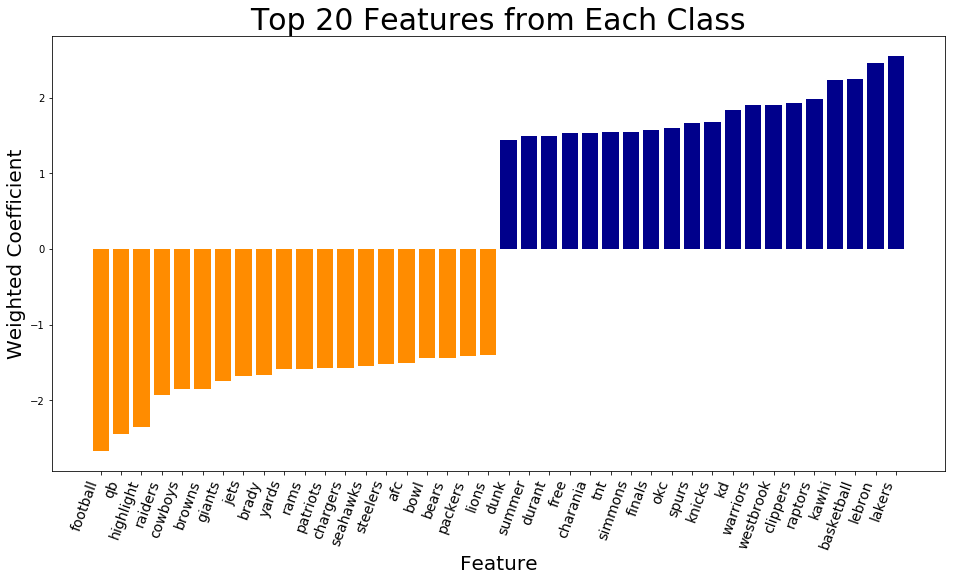

In [62]:
# plot svc model for r/nfl and r/nba
plot_coefficients(svc, tfidf.get_feature_names())

In [63]:
# print confusion matrix
make_cm(svc, test_raw, y_test, ['r/nfl', 'r/nba'])

       pred_r/nfl  pred_r/nba
r/nfl         408          39
r/nba          27         489
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       447
           1       0.93      0.95      0.94       516

    accuracy                           0.93       963
   macro avg       0.93      0.93      0.93       963
weighted avg       0.93      0.93      0.93       963



## Support Vector Machine Classifier: r/nba vs. r/CollegeBasketball
---

In this section I run a TF-IDF Vectorizor and the Support Vector Machine Classifier on the data collected from r/nba and r/collegebasketball. Given the relative imporantance of sport specific terms like "basketball" and "dunk" in the presious SVM model, I wanted to classify posts from subreddits that follow the same sport: r/nba and r/collegebasktball. This model performed well, posting an accuracy score of 91.39% and a weighted accuracy of 91%.

Like the SVM classifier for r/nba and r/nfl, this model tended to weight proper nouns like player names and team names high. Terms like "tournament", "transfer", and "commit" were given importance in r/collegebasktball as they used more widely those discussions than for r/nba, but instead of players, we find the names of coaches like "calipari" to be weighted heavily. Some interesting differentiators were "basketball" and "gif" which could fall within either subreddit, but were weighted heavily toward r/CollegeBasketball.

In [97]:
# train/test split our data
X = reddit_bb['text']
y = reddit_bb['is_nba']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [98]:
# instatiate pipeline with tfidf and svc
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(C = 1, kernel='linear', gamma = 'auto'))
])

In [99]:
# instantiate paramter grid for grisearch
svm_params = {
    'tfidf__max_features': [2000, 5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [.60, .75, .90],
    'tfidf__stop_words': [None, 'english']
}

In [100]:
# griseach through hyperparameters for SVC model
svm_gs = GridSearchCV(svm_pipe, param_grid=svm_params, cv=3, n_jobs=4)
svm_gs.fit(X_train, y_train)

# display best hyperparameters
svm_gs.best_params_

{'tfidf__max_df': 0.6,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

In [101]:
# check score from training data
svm_gs.best_estimator_.score(X_train, y_train)

0.9922297297297298

In [102]:
# check score from predictions on testing data
y_pred_class = svm_gs.best_estimator_.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9138804457953394

In [103]:
# fit tf-idf svc model for best hyperparameters
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 1), stop_words='english', max_df=.6)
train_raw = tfidf.fit_transform(X_train)
test_raw = tfidf.transform(X_test)

svc = SVC(C = 1, kernel='linear', gamma = 'auto')
svc.fit(train_raw, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

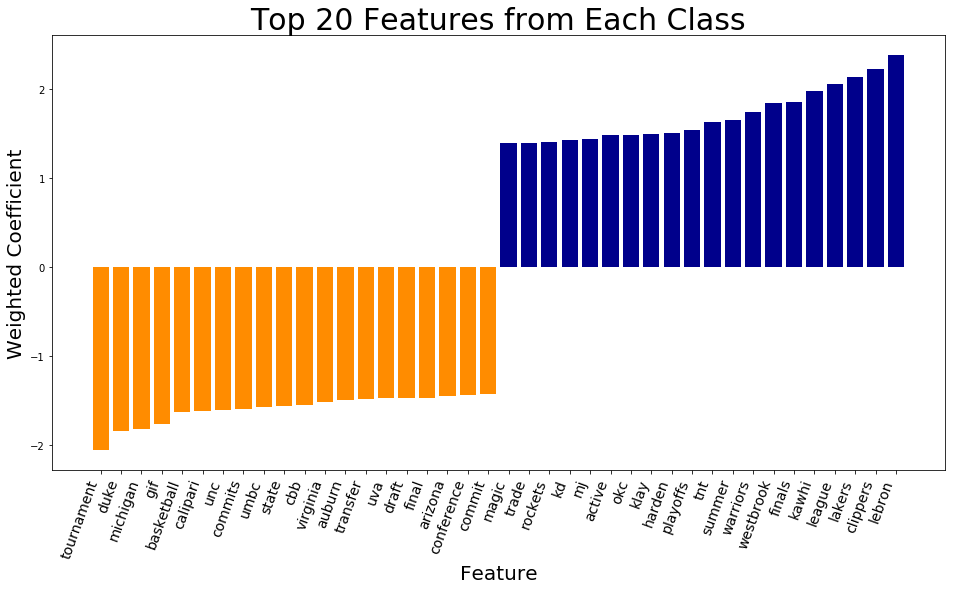

In [108]:
# plot svc model for r/nfl and r/nba
plot_coefficients(svc, tfidf.get_feature_names())

In [105]:
# generate confusion matrix and classification report
make_cm(svc, test_raw, y_test, ['r/CollegeBasketball', 'r/nba'])

                     pred_r/CollegeBasketball  pred_r/nba
r/CollegeBasketball                       426          45
r/nba                                      40         476
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       471
           1       0.91      0.92      0.92       516

    accuracy                           0.91       987
   macro avg       0.91      0.91      0.91       987
weighted avg       0.91      0.91      0.91       987



## Support Vector Machine Classifier: r/nfl vs. r/cfb
---

In this section I run a TF-IDF Vectorizor and the Support Vector Machine Classifier on the data collected from r/nfl and r/cfb, the NCAA Football Subreddit. This model performed well, posting an accuracy score of 92.43% and a weighted accuracy of 93%.

Like both SVM classifiers before, this model weighted proper nouns high, but in the case of r/cfb, there were very little in terms of players or coaches names. Related terms like "commits", "star", and "conference" were given importance in r/cfb.  Like r/CollegeBasketball, common words like "basketball" and "tweet"  were weighted heavily toward r/cfb.

In [109]:
# train/test split our data
X = reddit_fb['text']
y = reddit_fb['is_nfl']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [110]:
# set up our pipeline for tf-idf and svc
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(C = 1, kernel='linear', gamma = 'auto'))
])

In [111]:
# establish gridsearch parameters
svm_params = {
    'tfidf__max_features': [2000, 5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [.60, .75, .90],
    'tfidf__stop_words': [None, 'english']
}

In [112]:
# run grisearch for tfidf and svc
svm_gs = GridSearchCV(svm_pipe, param_grid=svm_params, cv=3, n_jobs=4)
svm_gs.fit(X_train, y_train)

# display best hyperparameters
svm_gs.best_params_

{'tfidf__max_df': 0.6,
 'tfidf__max_features': 20000,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': 'english'}

In [113]:
# check score from training data
svm_gs.best_estimator_.score(X_train, y_train)

0.9945175438596491

In [114]:
# check score from predictions on testing data
y_pred_class = svm_gs.best_estimator_.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9243421052631579

In [115]:
# fit tfidf and svc from best hyperparameters
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english', max_df=.60)
train_raw = tfidf.fit_transform(X_train)
test_raw = tfidf.transform(X_test)

svc = SVC(C = 1, kernel='linear', gamma = 'auto')
svc.fit(train_raw, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

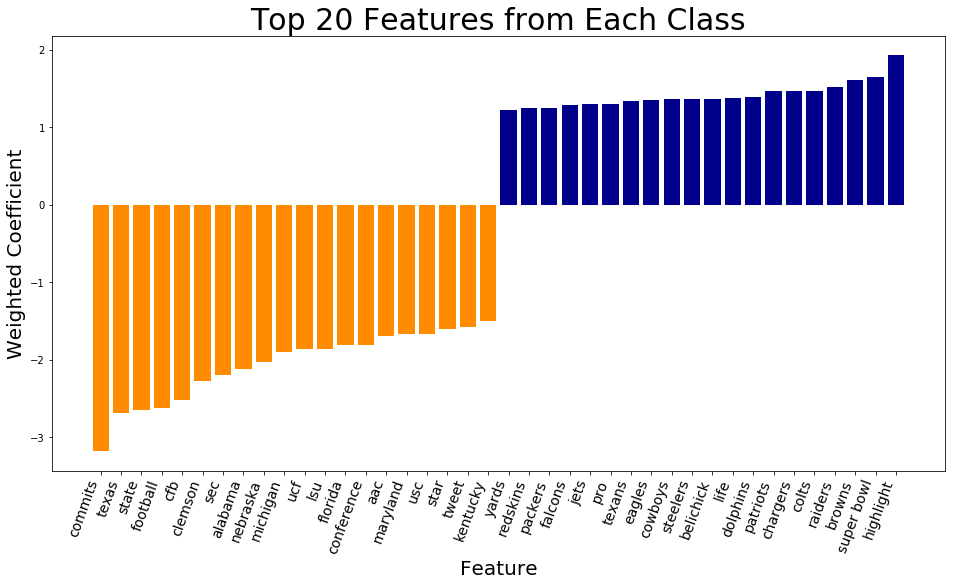

In [116]:
# plot svc model for r/nfl and r/nba
plot_coefficients(svc, tfidf.get_feature_names())

In [117]:
# generate confusion matrix and classification matrix
make_cm(svc, test_raw, y_test, ['r/cfb', 'r/nfl'])

       pred_r/cfb  pred_r/nfl
r/cfb         422          43
r/nfl          22         425
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       465
           1       0.91      0.95      0.93       447

    accuracy                           0.93       912
   macro avg       0.93      0.93      0.93       912
weighted avg       0.93      0.93      0.93       912

